<h1>PREPROCESSING DATA & DEFINE THE MODEL</h1>

In [98]:
import pandas as pd #pandas: For data manipulation and loading the dataset.
from sklearn.impute import SimpleImputer #SimpleImputer: Used for imputing missing values in the data (filling missing values).
from sklearn.preprocessing import StandardScaler, OneHotEncoder #StandardScaler: Standardizes numerical features by scaling them to have zero mean and unit variance.
#OneHotEncoder: Encodes categorical variables into numerical data by creating binary columns for each category.
from sklearn.compose import ColumnTransformer #ColumnTransformer: Allows applying different preprocessing pipelines to numerical and categorical features in a single step
from sklearn.pipeline import Pipeline #Pipeline: Chains preprocessing steps and model training into a single step.
from sklearn.model_selection import train_test_split #train_test_split: Splits the data into training and testing sets.
from sklearn.ensemble import RandomForestClassifier #RandomForestClassifier: A machine learning model used for classification tasks.
from sklearn.metrics import accuracy_score, classification_report #accuracy_score and classification_report: Metrics for model evaluation.
from sklearn.utils import resample #accuracy_score and classification_report: Metrics for model evaluation.
# from imblearn.over_sampling import SMOTE
from sklearn.base import BaseEstimator, TransformerMixin

# Load the dataset
df = pd.read_csv('titanic_data.csv', keep_default_na=False)

#Extract title from the "Name" column
df['Title'] = df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

df['Survived'] = df['Survived'].fillna(df['Survived'].mode()[0])


# features and target
attributes = df.drop('Survived', axis=1)
target = df['Survived']

# # Apply SMOTE
# smote = SMOTE(random_state=42)
# X_smote, y_smote = smote.fit_resample(attributes, target)

# # Identify numerical and categorical columns
# numeric_features = attributes.select_dtypes(include=['int64', 'float64']).columns
# categorical_features = target.select_dtypes(include=['object']).columns


numeric_features = ['PassengerId', 'Pclass', 'SibSp', 'Parch', 'Fare']  # Numeric columns
categorical_features = ['gender', 'Embarked', 'Title']  # Relevant categorical columns
drop_features = ['Name', 'Ticket', 'Cabin'] #irrelevant columns
df = df.drop(columns=drop_features, errors='ignore')
#handle outliers
# def handle_outliers(df, column, lower_quantile=0.05, upper_quantile=0.95):
   
#     lower_bound = df[column].quantile(lower_quantile)
#     upper_bound = df[column].quantile(upper_quantile)
#     df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)
# for col in numeric_features:
#     handle_outliers(df, col)



#Custom Outlier Handler Transformer
class OutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.05, upper_quantile=0.95):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile

    def fit(self, X, y=None):
        self.bounds = {}
        for col in X.columns:
            lower_bound = X[col].quantile(self.lower_quantile)
            upper_bound = X[col].quantile(self.upper_quantile)
            self.bounds[col] = (lower_bound, upper_bound)
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in X.columns:
            lower_bound, upper_bound = self.bounds[col]
            X_transformed[col] = X_transformed[col].clip(lower=lower_bound, upper=upper_bound)
        return X_transformed
    



#pipeline for numerical preprocessing
numerical_transformer = Pipeline(steps=[
    ('outlier_handler', OutlierHandler()),  # Handle outliers
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing values with the mean
    ('scaler', StandardScaler())  # Scale numerical data
])



# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing values with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical features
])

# Combine preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)


#depends on decision trees
#define the model
rf_model = RandomForestClassifier(n_estimators=500, class_weight='balanced', random_state=42)


# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', rf_model)
])

# Upsampling
df_majority = df[df['Survived'] == 0]
df_minority = df[df['Survived'] == 1]

df_minority_upsampled = resample(
    df_minority,
    replace=True,
    n_samples=len(df_majority),
    random_state=42
)

df_upsampled = pd.concat([df_majority, df_minority_upsampled])

# Use upsampled data for training/testing
attributes_upsampled = df_upsampled.drop('Survived', axis=1)
target_upsampled = df_upsampled['Survived']


#split into train and test
xtrain, xtest, ytrain, ytest = train_test_split(attributes_upsampled, target_upsampled, test_size=0.3, random_state=42, stratify=target_upsampled)


# train model
pipeline.fit(xtrain, ytrain)

#test model
ypred = pipeline.predict(xtest)

pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('outlier_handler',
                                                                   OutlierHandler()),
                                                                  ('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['PassengerId', 'Pclass',
                                                   'SibSp', 'Parch', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['gender', 'Embarked',
                                                   'Title'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=500, random_state=42))])

In [58]:
encoded_features = pipeline.named_steps['preprocessor'].named_transformers_['cat']['onehot'].get_feature_names_out()
print("Encoded features:", encoded_features)

Encoded features: ['x0_female' 'x0_male' 'x1_' 'x1_C' 'x1_Q' 'x1_S' 'x2_Col' 'x2_Countess'
 'x2_Don' 'x2_Dr' 'x2_Jonkheer' 'x2_Major' 'x2_Master' 'x2_Miss' 'x2_Mlle'
 'x2_Mme' 'x2_Mr' 'x2_Mrs' 'x2_Ms' 'x2_Rev']


In [59]:
imputed_values = pipeline.named_steps['preprocessor'].named_transformers_['cat']['imputer'].statistics_
print("Imputed values for categorical features:", imputed_values)

Imputed values for categorical features: ['male' 'S' 'Mr']


In [83]:
print(df_upsampled.isnull().sum())

PassengerId    0
Survived       0
Pclass         0
gender         0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Title          0
dtype: int64


<H1>CLASSIFICATION REPORT</H1>

In [84]:
from sklearn.metrics import classification_report
report = classification_report(ytest, pipeline.predict(xtest))
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.81      0.86       165
           1       0.83      0.93      0.88       165

    accuracy                           0.87       330
   macro avg       0.88      0.87      0.87       330
weighted avg       0.88      0.87      0.87       330



In [100]:
from sklearn.metrics import precision_score, recall_score, f1_score

#Precision : the accuracy of positive predictions.
# 85.2% of the instances predicted as positive are actually positive.
print("Precision:", precision_score(ytest, ypred))

#Recall:the proportion of actual positives correctly identified by the model.
#94.5% of the true positives were identified.
print("Recall:", recall_score(ytest, ypred))

#F1 Score: This is the harmonic mean of precision and recall,
# providing a single measure of the model's performance that balances both metrics.
# 0.897 suggests a strong performance overall, with good balance between precision and recall.
print("F1 Score:", f1_score(ytest, ypred))


Precision: 0.8333333333333334
Recall: 0.9393939393939394
F1 Score: 0.8831908831908832


<h1>ACCURACY</H1>

In [101]:
# Evaluate the model
accuracy = pipeline.score(xtest, ytest)
print(f"Accuracy on test set: {accuracy:.2f}")

Accuracy on test set: 0.88


<H1> PREDICT VS ACTUAL</H1>

In [89]:
#Actual VS Predicted 
y_pred = pipeline.predict(xtest)
results_df = pd.DataFrame({
    'Actual': ytest,
    'Predicted': y_pred
})
print("Actual vs Predicted Values:")
print(results_df)

Actual vs Predicted Values:
     Actual  Predicted
380       1          1
141       1          1
283       1          1
143       0          0
480       0          1
..      ...        ...
148       0          0
600       1          1
836       0          0
180       0          0
192       1          1

[330 rows x 2 columns]


<h1>CONFUSION MATRIX</h1>

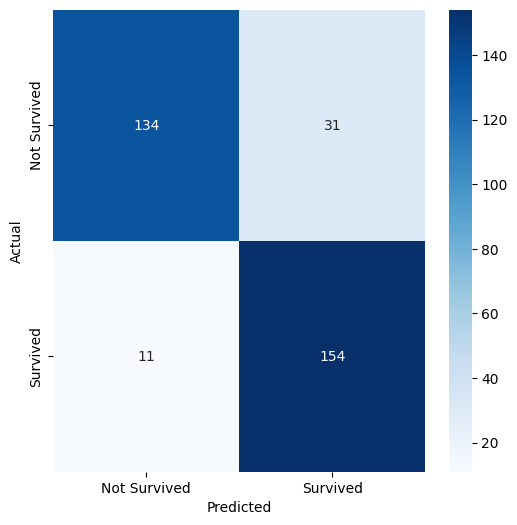

In [72]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(ytest, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


<H1>Test Model With Unseen Data Entered Manually</h1>

In [74]:
def predict_unseen_sample():
   
    try:
        
        num_samples = int(input("\nHow many unseen samples would you like to test with? "))

        for i in range(num_samples):
            print(f"\nInput data for sample {i + 1}:")
            
            pclass = int(input("Pclass (1, 2, 3): "))
            name = input("Name (e.g., John): ")
            gender = input("Sex (male/female): ")
            age = float(input("Age (e.g., 28): "))
            sibsp = int(input("Siblings/Spouses aboard (e.g., 0, 1): "))
            parch = int(input("Parents/Children aboard (e.g., 0, 1): "))
            fare = float(input("Fare (e.g., 50): "))
            embarked = input("Embarked (S, C, Q): ")

            
            manual_input = {
                "Pclass": pclass,
                "Name": name,
                "gender": gender,
                "Age": age,
                "SibSp": sibsp,
                "Parch": parch,
                "Fare": fare,
                "Embarked": embarked,
                "PassengerId": 0,
                "Ticket": 0,
                "Cabin": 0
            }

        
            unseen_df = pd.DataFrame([manual_input])


            unseen_df['Title'] = unseen_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

        
            prediction = pipeline.predict(unseen_df)

            unseen_df['Prediction'] = prediction
            print("\nPrediction made successfully!")
            print(unseen_df[['Name', 'Prediction']])

    except Exception as e:
        print("\nError predicting unseen sample:", e)

<h1> Call Function</h1>

In [75]:

predict_unseen_sample()


Input data for sample 1:

Prediction made successfully!
   Name  Prediction
0  sara           1

Input data for sample 2:

Prediction made successfully!
   Name  Prediction
0  john           0

Input data for sample 3:

Prediction made successfully!
   Name  Prediction
0  mona           1


<H1>Test Model With Unseen Data Entered as a Dictionary</h1>

In [76]:

def predict_unseen_sample(sample_data):
  
    try:
        
        required_columns = [
            "Pclass", "Name", "gender", "Age", "SibSp", "Parch", "Fare", "Embarked",
            "PassengerId", "Ticket", "Cabin"
        ]

        
        for col in required_columns:
            if col not in sample_data:
                raise ValueError(f"Missing column in input data: {col}")

        
        unseen_df = pd.DataFrame([sample_data])

    
        unseen_df['Title'] = unseen_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

        
        prediction = pipeline.predict(unseen_df)

    
        unseen_df['Survived_Prediction'] = prediction
        print("Prediction made successfully!")
        print(unseen_df[['PassengerId', 'Name', 'Survived_Prediction']])
    except Exception as e:
        print("Error predicting unseen sample:", e)



manual_input = {
    "PassengerId": 1,
    "Pclass": 1,
    "Name": "mona",
    "gender": "female",
    "Age": 28,
    "SibSp": 0,
    "Parch": 0,
    "Fare": 50,
    "Embarked": "S",
    "Ticket": "A/5 21171",
    "Cabin": "C85"
}

predict_unseen_sample(manual_input)


manual_input_2 = {
    "PassengerId": 2,
    "Pclass": 3,
    "Name": "Mostafa",
    "gender": "male",
    "Age": 32,
    "SibSp": 1,
    "Parch": 0,
    "Fare": 25,
    "Embarked": "C",
    "Ticket": "PC 17599",
    "Cabin": "None"
}

predict_unseen_sample(manual_input_2)


Prediction made successfully!
   PassengerId  Name  Survived_Prediction
0            1  mona                    1
Prediction made successfully!
   PassengerId     Name  Survived_Prediction
0            2  Mostafa                    0


<H1>Test Model With Unseen Data Entered as a CSV File</h1>

In [77]:
def predict_unseen_sample(file_path):
  
    try:
        unseen_df = pd.read_csv(file_path)
        print("Sample loaded successfully!")

        unseen_df['Title'] = unseen_df['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)

        unseen_df.dropna(subset=['Age', 'Fare', 'Sex'], inplace=True)

        prediction = pipeline.predict(unseen_df)

        unseen_df['Survived_Prediction'] = prediction
        print("Prediction made successfully!")
        print(unseen_df[['Name', 'Survived_Prediction']])
    except Exception as e:
        print("Error loading or predicting unseen sample:", e)




In [78]:
unseen_file_path = 'unseen_sample.csv'
predict_unseen_sample(unseen_file_path)

Error loading or predicting unseen sample: [Errno 2] No such file or directory: 'unseen_sample.csv'


C:\Users\yumenna ezzat\AppData\Local\Temp\ipykernel_18328\612593065.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=target, palette="viridis")
c:\Users\yumenna ezzat\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\yumenna ezzat\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


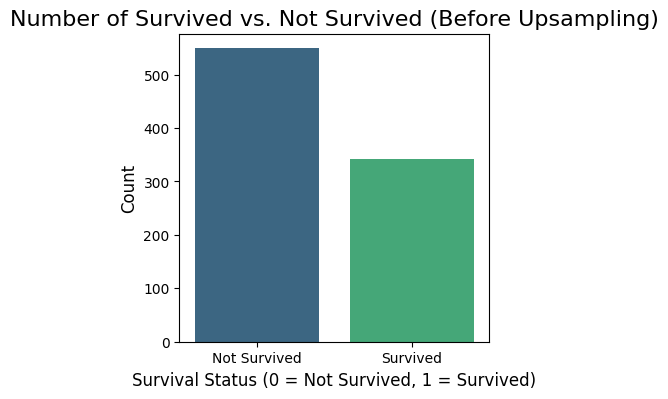

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(4, 4))
sns.countplot(x=target, palette="viridis")
plt.title("Number of Survived vs. Not Survived (Before Upsampling)", fontsize=16)
plt.xlabel("Survival Status (0 = Not Survived, 1 = Survived)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Not Survived', 'Survived'], fontsize=10)
plt.show()

C:\Users\yumenna ezzat\AppData\Local\Temp\ipykernel_18328\1128044408.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df_upsampled['Survived'], palette="viridis")
c:\Users\yumenna ezzat\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
c:\Users\yumenna ezzat\AppData\Local\Programs\Python\Python312\Lib\site-packages\seaborn\_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get

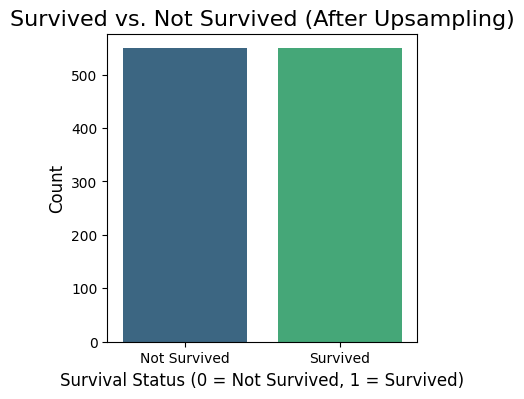

In [80]:

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(4, 4))
sns.countplot(x=df_upsampled['Survived'], palette="viridis")
plt.title("Survived vs. Not Survived (After Upsampling)", fontsize=16)
plt.xlabel("Survival Status (0 = Not Survived, 1 = Survived)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks([0, 1], ['Not Survived', 'Survived'], fontsize=10)
plt.show()

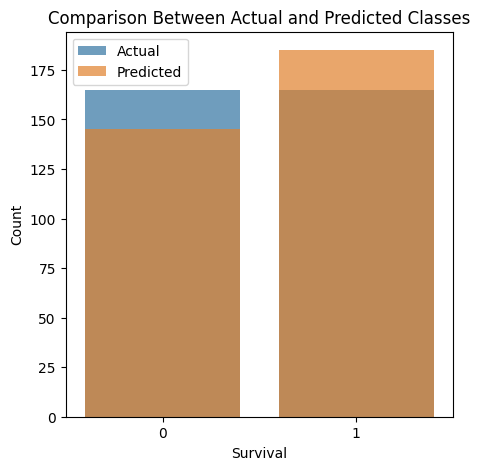

In [81]:

results_df = pd.DataFrame({'Actual': ytest, 'Predicted': y_pred})

plt.figure(figsize=(5, 5))
sns.countplot(x='Actual', data=results_df, alpha=0.7, label="Actual")
sns.countplot(x='Predicted', data=results_df, alpha=0.7, label="Predicted")
plt.xlabel('Survival')
plt.ylabel('Count')
plt.title('Comparison Between Actual and Predicted Classes')
plt.legend()
plt.show()

